# Ocean Wave Data from Buoys Reported by National Data Buoy Center (NDBC)

In [3]:
# Let's install and import the required libraries
# Uncomments the following lines in case you don't have the libraries installed on your machine
#!conda install -c conda-forge beautifulsoup4 --yes 
#!conda install -c conda-forge lxml --yes
#!conda install -c conda-forge requests --yes
#!conda install -c conda-forge folium=0.9 --yes
#!conda install -c conda-forge windrose=1.6.7 --yes

import sys
from bs4 import BeautifulSoup
import requests
from urllib.request import urlopen, Request
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import folium
import json
from datetime import date, timedelta, datetime
# Put figures in the center
from IPython.core.display import HTML
import seaborn as sns
print('All libraries installed and imported')

All libraries installed and imported


Now, let's get the list of all the buoys from National Data Buoy Center. To get access to the data, we need to first create an account [here](https://data.planetos.com/datasets/noaa_ndbc_stdmet_stations?utm_source=github&utm_medium=notebook&utm_campaign=ndbc-wavewatch-iii-notebook). Once the account is created, API Key can be found under __Account Setting__. The data set id for National Data Buoy Center (NDBC) Standard Meteorological Data is __noaa_ndbc_stdmet_stations__. This data typically updates every hour.

### First, we use an API to get Buys' latitude, longitude and names.

In [4]:
# @ hidden
APIKey = 'b922f59d7e3042bd9b77770083d582eb'
DatasetID = 'noaa_ndbc_stdmet_stations'

In [5]:
API_url = 'http://api.planetos.com/v1/datasets/%s/stations?apikey=%s' % (DatasetID, APIKey)
request = requests.get(API_url).json() #Request(API_url)
Stations = pd.DataFrame(request['station'])
#response = urlopen(request)
#API_data_locations = json.loads(response.read())
#print(json.dumps(request['station'][:], indent=2))
df_stations = pd.DataFrame(Stations.columns)
for indx, StName in enumerate(Stations.columns):
    df_stations.loc[indx,1]=Stations.loc['SpatialExtent'][indx]['coordinates'][0]
    df_stations.loc[indx,2]=Stations.loc['SpatialExtent'][indx]['coordinates'][1]

df_stations.columns = ['Station_Name','Latitude','Longitude']
print('number of stations:',df_stations.shape[0])
df_stations.head()

number of stations: 919


Station_Name    Latitude  Longitude
0        42390  -94.898003  26.129000
1        keca2 -131.625000  55.331001
2        bltm2  -76.578003  39.266998
3        gelo1  -80.973999  41.860001
4        psbc1 -121.887001  38.042000

In [6]:
def BuoyLocationPlot(MapInput,DataFrameInput,Marker=False):
    # instantiate a feature group for the buoys in the dataframe
    buoys = folium.map.FeatureGroup(name="Buoys Locations")
    
    # loop through and add each to the feature group
    for lat, lng, label in zip(DataFrameInput.Longitude, DataFrameInput.Latitude,DataFrameInput.Station_Name):
        buoys.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=6, # define how big you want the circle markers to be
                color='red',
                fill=True,
                fill_color='yellow',
                fill_opacity=0.6,
                popup=label
            )
        )

    
    if Marker==True:
        latitudes = list(DataFrameInput.Longitude)
        longitudes = list(DataFrameInput.Latitude)
        labels = list(DataFrameInput.Station_Name)
        for lat, lng, label in zip(latitudes, longitudes, labels):
            folium.Marker([lat, lng], popup=label).add_to(MapInput)    
    
    MapInput.add_child(buoys)
    return MapInput

In [7]:
#Let's plot all the buoy stations
# Create the map
figmp=folium.Figure(width=1300, height=700)
WorldMap_map = folium.Map(location=[17.6078, -8.0817],tiles="Stamen Toner",zoom_start=2).add_to(figmp)
folium.TileLayer("Stamen Toner").add_to(WorldMap_map) 
folium.TileLayer("OpenStreetMap").add_to(WorldMap_map) 
folium.TileLayer("Stamen Terrain").add_to(WorldMap_map)
BuoyLocationPlot(WorldMap_map,df_stations)
folium.LayerControl().add_to(WorldMap_map)
WorldMap_map.save("WorldMapBuoys.html")
WorldMap_map

### Since the data from this API is not complete for each buoy and also have missing columns, we use the National Data Buoy Center website directly at https://www.ndbc.noaa.gov/ to get our information.

There is a list of stations categorized by their owners [here](https://www.ndbc.noaa.gov/to_station.shtml)

In [8]:
source=requests.get('https://www.ndbc.noaa.gov/to_station.shtml').text
soup = BeautifulSoup(source,'lxml')
Owners=[]
BuoyData={}

for owner in soup.find_all('h4'):
    Owners.append(owner.text)
for indx,table in enumerate(soup.find_all('pre')):
    #print(indx,table.text)
    try:
        BuoyData[Owners[indx]]=table.text.replace('\n','').strip()
    except:
        BuoyData[Owners[indx]]=table


In [9]:
# First, let's make all the station names uppercase since they are in uppercase format in the website
df_stations['Station_Name']=df_stations['Station_Name'].str.upper()
# Now, let's put this data and the data containing the latitudes and longitudes in the same dataframe
newlist1=[]
newlist2=[]
for indx1 in range(df_stations.shape[0]):
    for indx2,owner in enumerate(Owners):
        if (df_stations.iloc[indx1,0] in BuoyData[owner]):
            newlist1.append(owner)
            newlist2.append(df_stations.iloc[indx1,0])


In [10]:
df_stations0=pd.DataFrame({'Station_Name':newlist2,'Owner':newlist1})
df_full1=pd.merge(df_stations0, df_stations, on='Station_Name')
print('Number of Stations:',df_full1.shape[0])
df_full1.head()

Number of Stations: 913


Station_Name                        Owner    Latitude  Longitude
0        42390           Shell Oil Stations  -94.898003  26.129000
1        KECA2                 NOS Stations -131.625000  55.331001
2        BLTM2                 NOS Stations  -76.578003  39.266998
3        GELO1  NWS Eastern Region Stations  -80.973999  41.860001
4        PSBC1                 NOS Stations -121.887001  38.042000

In [11]:
def BuoyLocationPlot2(buoys,MapInput,DataFrameInput,colorm,fill_colorm,Marker=False):
    # instantiate a feature group for the buoys in the dataframe
    #buoys = folium.map.FeatureGroup()
    
    # loop through and add each to the feature group
    for lat, lng, label in zip(DataFrameInput.Longitude, DataFrameInput.Latitude, DataFrameInput.Station_Name):
        buoys.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=6, # define how big you want the circle markers to be
                color=None,
                fill=True,
                fill_color=fill_colorm,
                fill_opacity=0.8,
                popup=label
            )
        )

    
    if Marker==True:
        latitudes = list(DataFrameInput.Longitude)
        longitudes = list(DataFrameInput.Latitude)
        labels = list(DataFrameInput.Station_Name)
        for lat, lng, label in zip(latitudes, longitudes, labels):
            folium.Marker([lat, lng], popup=label).add_to(MapInput)    
    
    
    return buoys

### Available Data for each buoy
Not all the buys have data available for the same period of time. Some have been working for a short period of time, some had worked before but not any more, and some of them recently started working and collecting data. To have a full collection of the time range of the data available for each buoy, the following page is used from National Data Buoy Center website:
https://www.ndbc.noaa.gov/historical_data.shtml#stdmet. It is worth mentioning that we are only interested in Standard Meterological data. To have a better understanding of  Standard Meterological data, look at the information provided here: https://www.ndbc.noaa.gov/measdes.shtml

In [12]:
source=requests.get('https://www.ndbc.noaa.gov/historical_data.shtml').text
soup = BeautifulSoup(source,'lxml')

BuoyYearData={}
BigTable=soup.find_all('ul')[1]
SmallTable=BigTable.li.ul

for indx,subtable in enumerate(SmallTable.find_all('li')):
    StatName=SmallTable.find_all('li')[indx].text.split('\n')[0].replace(':','')
    est=SmallTable.find_all('li')[indx].text.split('\n')
    tmplist = est[1:]
    for indx00,value in enumerate(tmplist):
        tmplist[indx00] = tmplist[indx00].strip()
    del tmplist[-1]
    BuoyYearData[StatName]=tmplist
    

    
    
    
# Let's add one column for each year to the main dataframe
YearsRange = range(1970,2019)
df_full = df_full1.copy(deep=True)
df_full.set_index(['Station_Name'],inplace=True)
for indx, year in enumerate(YearsRange):
    df_full[year] = None

for indx,StName in enumerate(df_full.index):
    first=np.array(df_full.loc[StName][4:].index).astype('int64')
    try:
        second=np.array(BuoyYearData[StName]).astype('int64')
        df_full.loc[StName ,np.intersect1d(first,second)]=1
    except:
        df_full.loc[StName ,np.intersect1d(first,second)]=None

In [13]:
# Plotting the buoys with their corresponding owners
figmp=folium.Figure(width=1300, height=700)
WorldMap_map2 = folium.Map(location=[17.6078, -8.0817],tiles="Stamen Toner",zoom_start=2).add_to(figmp)
color=iter(plt.cm.rainbow(np.linspace(0,1,len(Owners))))
for indx,owner in enumerate(Owners):
    clr=matplotlib.colors.to_hex(next(color))
    feature_group = folium.map.FeatureGroup(name=owner)
    df_tmp = df_full1[df_full1['Owner']==owner]
    buoys=BuoyLocationPlot2(feature_group,WorldMap_map2,df_tmp,clr,clr)
    WorldMap_map2.add_child(buoys,name=owner,index=indx)
    
folium.TileLayer("Stamen Toner").add_to(WorldMap_map2) 
folium.TileLayer("OpenStreetMap").add_to(WorldMap_map2) 
folium.TileLayer("Stamen Terrain").add_to(WorldMap_map2)
WorldMap_map2.add_child(folium.map.LayerControl())
WorldMap_map2.save("WorldMapBuoysOwners.html")
WorldMap_map2

### Get the data for a specific buoy

Enter Buoy's name: 44025


Available annual data for this buoy: ['1975', '1976', '1977', '1978', '1979', '1980', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


Year: 2018


Is data for buoy 44025 availabale during year 2018? Yes


Do you want the data for the whole year? (Yes/No) no
Enter the start date in the format DDMM like 10Jan:  25Feb
Enter the end date in the format DDMM like 25Dec:  01Dec



start date: 2018-02-25 00:00:00
end date: 2018-12-01 00:00:00

Now, let's continue!

https://www.ndbc.noaa.gov/view_text_file.php?filename=44025h2018.txt.gz&dir=data/historical/stdmet/
Download is done!
Generating the plots ...



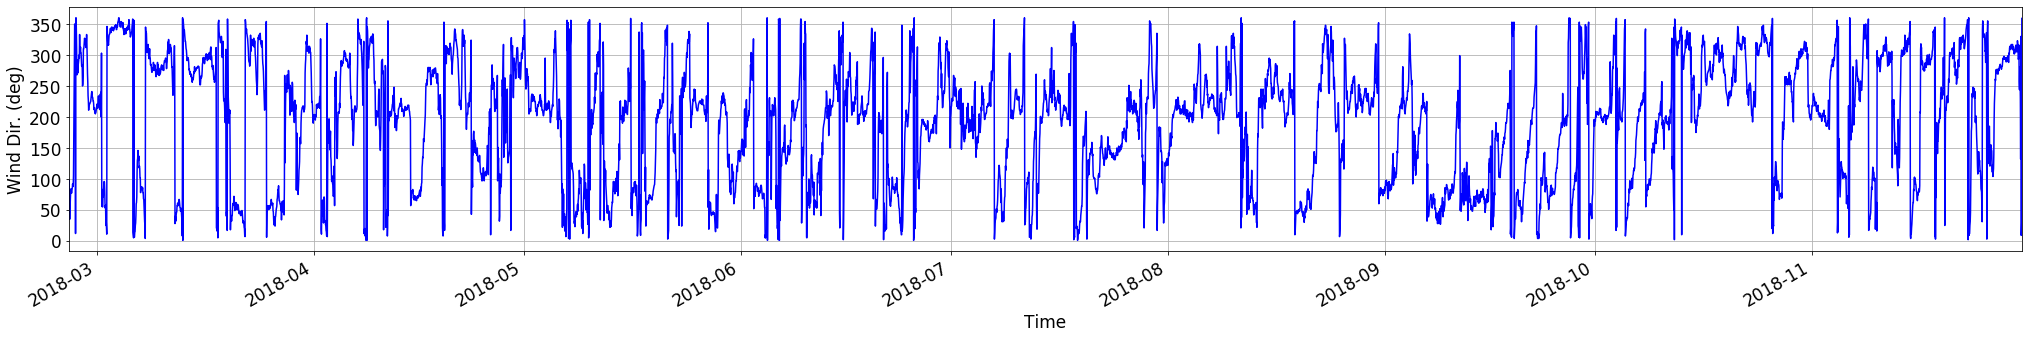

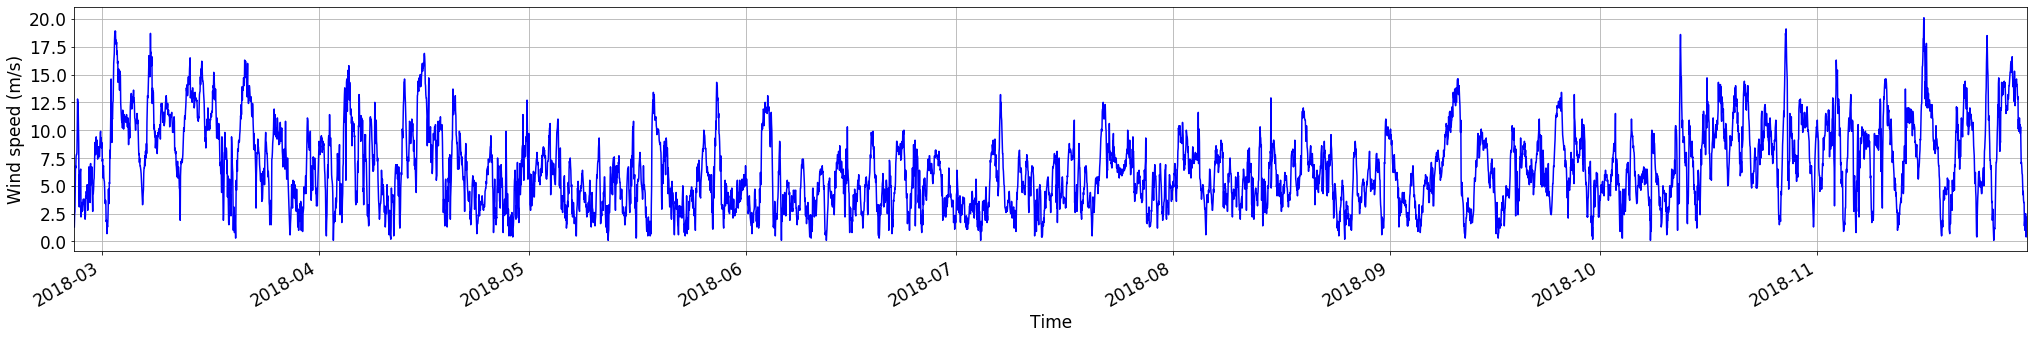

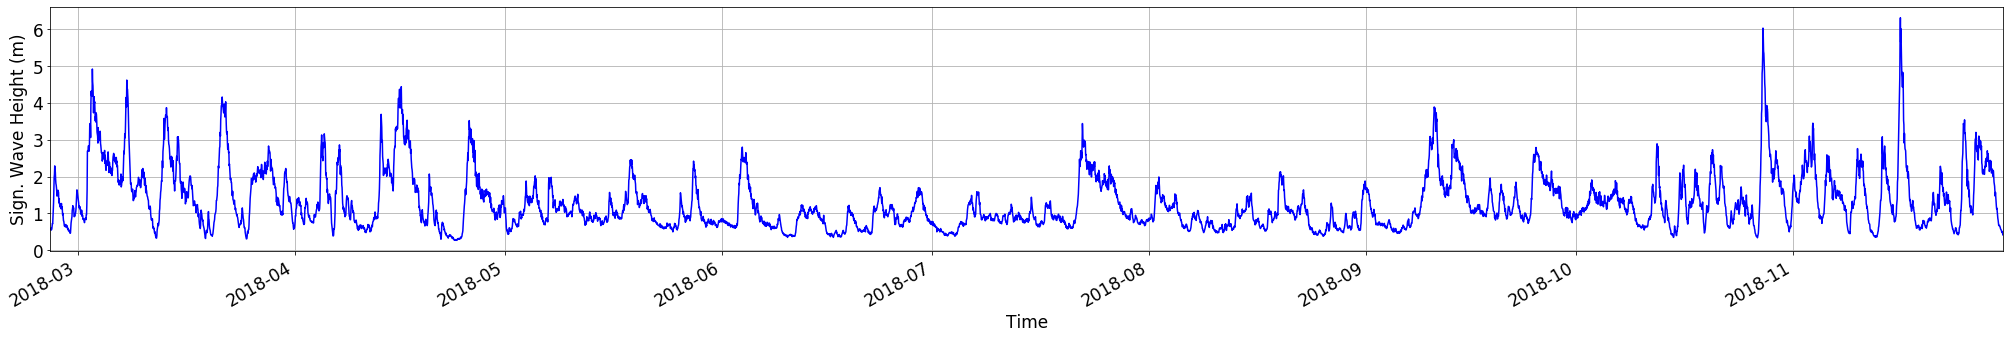

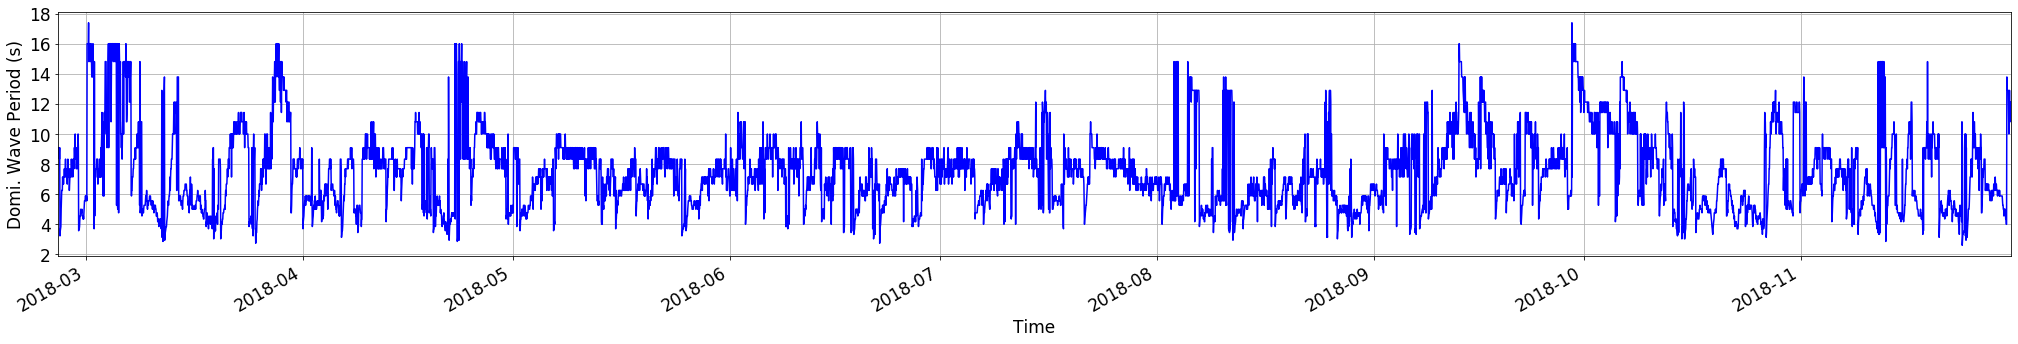

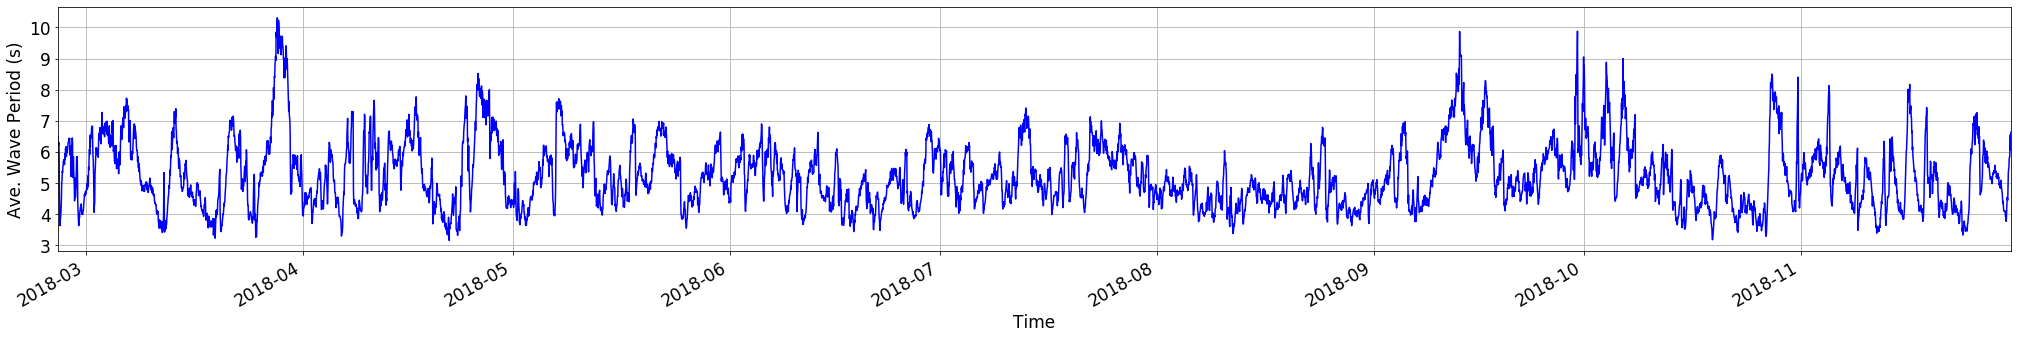

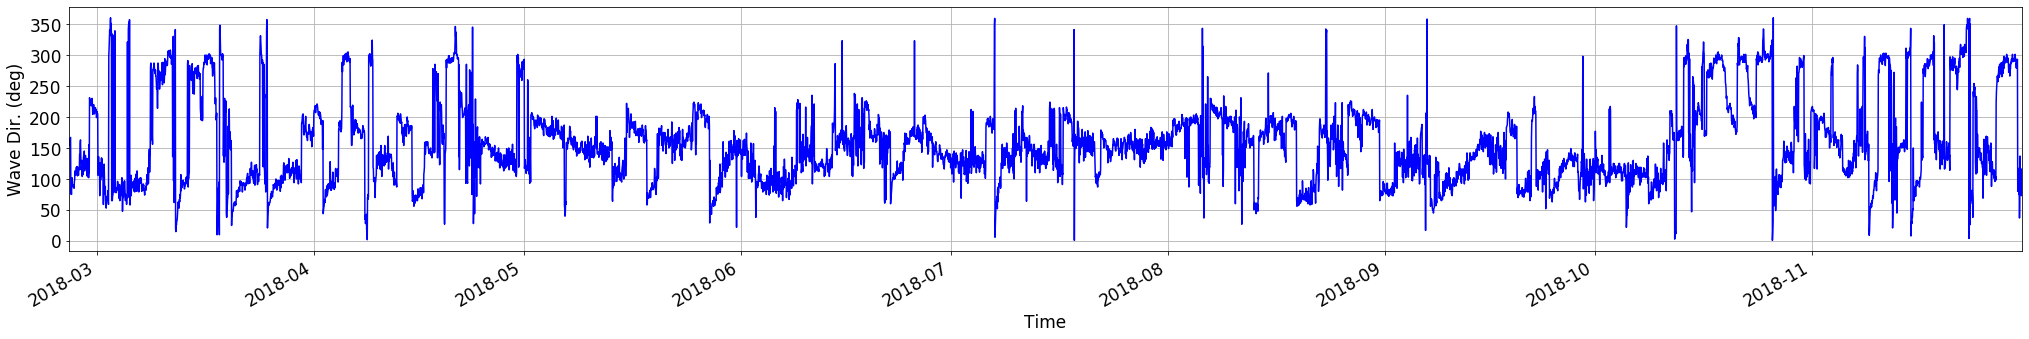

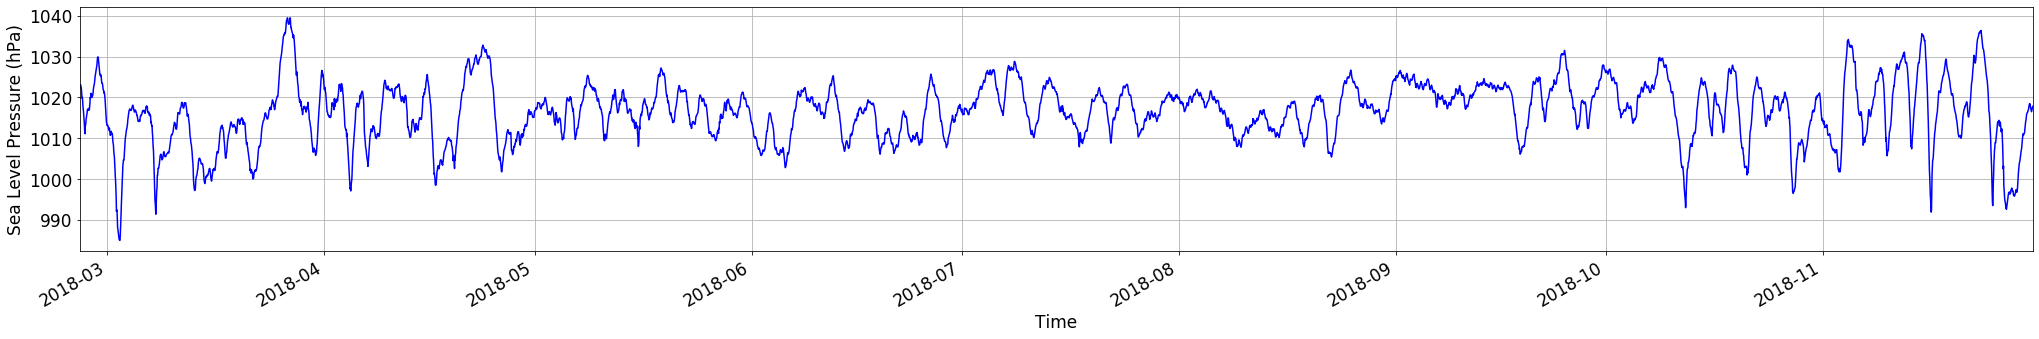

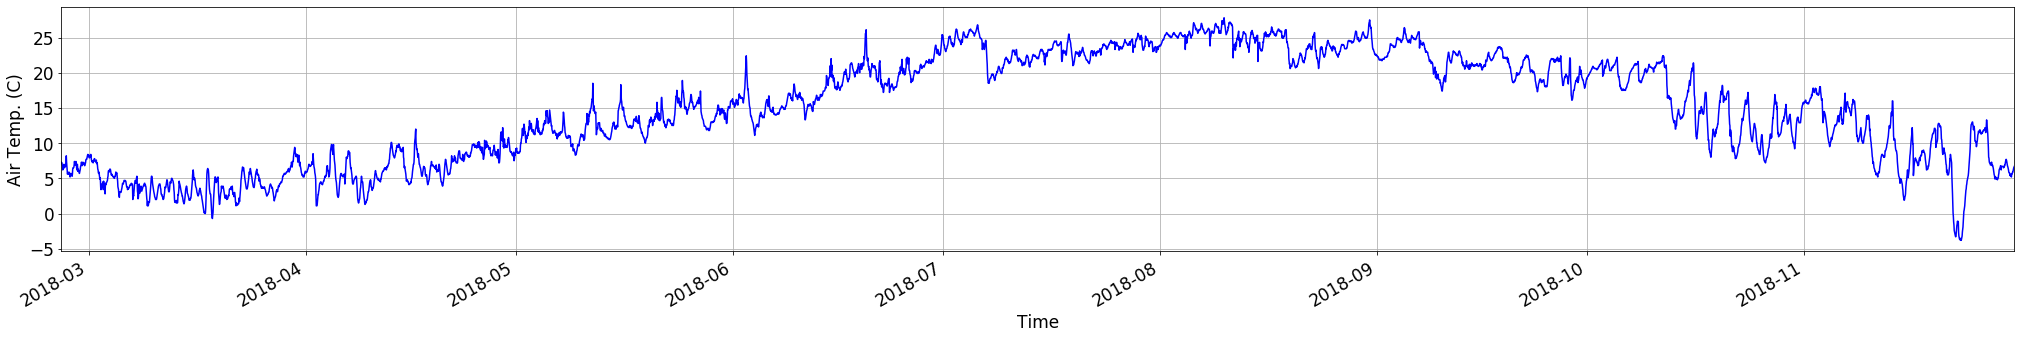

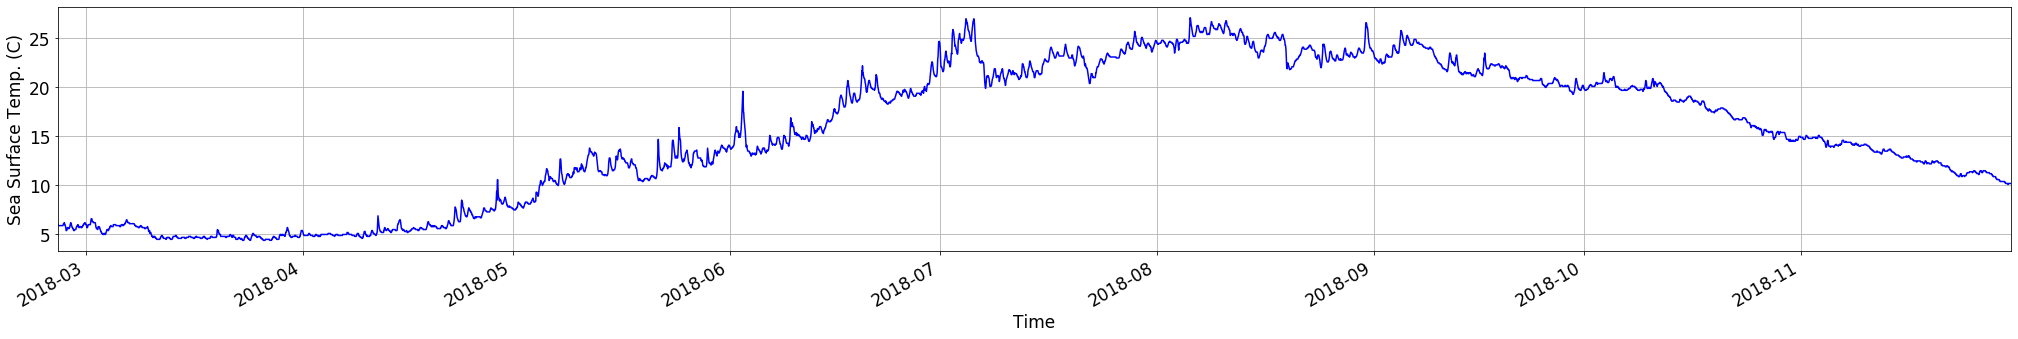

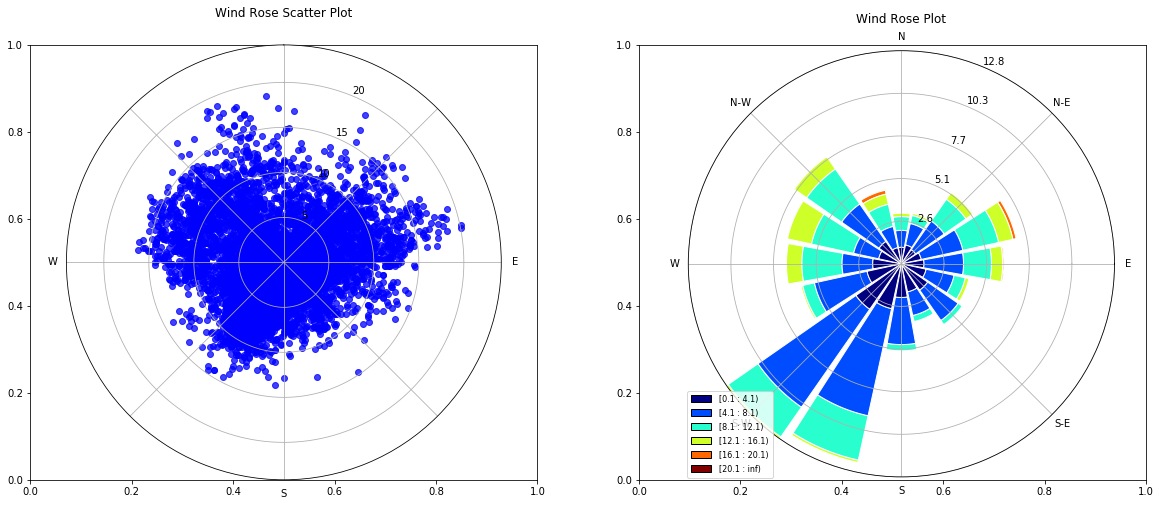

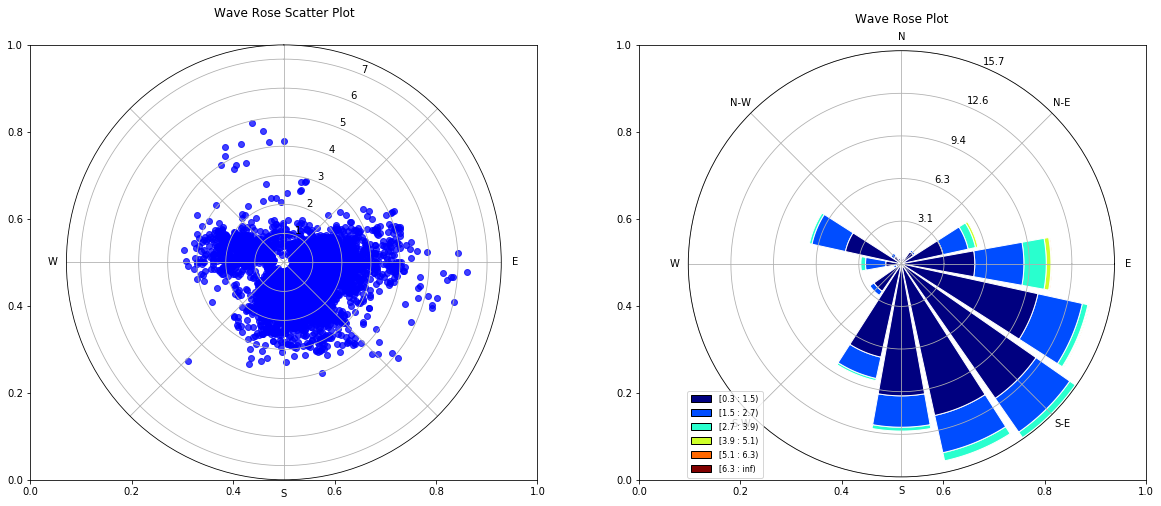

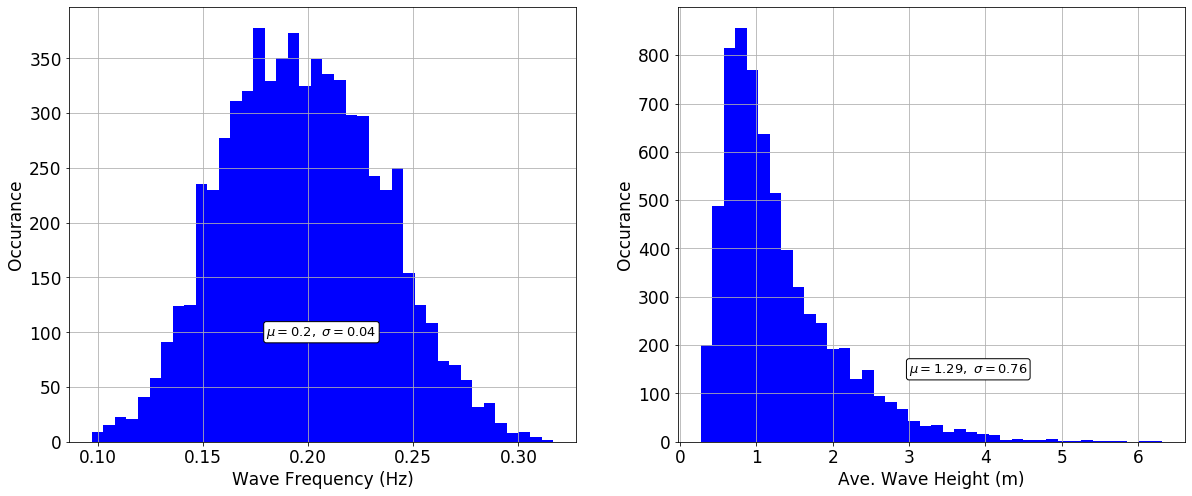

In [14]:
DumVar="No"
while DumVar=="No":
    BName=input("Enter Buoy's name:")
    try:
        print('Available annual data for this buoy:',BuoyYearData[BName])
    except:
        sys.exit('Error! There is no such buoy!!')
    BYear=input("Year:")
    DumVar="Yes" if ( df_full.loc[BName,int(BYear)]==1 ) else "No"
    print("Is data for buoy {} availabale during year {}? {}".format(BName,BYear,DumVar))
    DumVar2=input('Do you want the data for the whole year? (Yes/No)')
    if ( (DumVar2=="No" or DumVar2=="no") and (DumVar=="Yes") ):
        startD=input('Enter the start date in the format DDMM like 10Jan: ')
        endD=input('Enter the end date in the format DDMM like 25Dec: ')
        date_start = startD+str(BYear)
        date_end = endD+str(BYear)
        date_st = datetime.strptime(date_start, "%d%b%Y")
        date_en = datetime.strptime(date_end, "%d%b%Y")
        print()
        print('start date:',date_st)
        print('end date:',date_en)

print()
print("Now, let's continue!")
print()
url = "https://www.ndbc.noaa.gov/view_text_file.php?filename={}h{}.txt.gz&dir=data/historical/stdmet/".format(BName.lower(),BYear)
print("Downloading the data ...")
print(url)
df_BName = pd.read_csv(url,delim_whitespace=True, skiprows=range(1,2))
print('Download is done!')




# Concatonates (#YY MM DD hh mm) into one column as DATE
df_BName.rename(columns={'#YY':'year','MM':'month','DD':'day','hh':'hour','mm':'minute'},inplace=True)
df_BName['DATE']=pd.to_datetime(df_BName[['year', 'month', 'day','hour','minute']])
df_BName.drop(columns=['year','month','day','hour','minute'],inplace=True)
if (DumVar2=="No" or DumVar2=="no"):
    df_BName=df_BName.loc[(df_BName['DATE']>=date_st) & (df_BName['DATE']<=date_en)]
    df_BName.sort_values(by='DATE',ascending=False,inplace=True)
    df_BName.reset_index(drop=True,inplace=True)
    
listLabels = ['Wind Dir. (deg)', 'Wind speed (m/s)', 'Sign. Wave Height (m)', 'Domi. Wave Period (s)',\
              'Ave. Wave Period (s)','Wave Dir. (deg)', 'Sea Level Pressure (hPa)','Air Temp. (C)', 'Sea Surface Temp. (C)',\
              'Dewpoint Temp.','Station Visib. (nautical miles)','Water Level']
df_BName.drop(columns=['GST'],inplace=True)
df_BName.head()




# Cleaning up the trivial and non-informative columns
Labels = []
tmpdf=df_BName.describe().loc['min']==df_BName.describe().loc['max'] # When max and min value in a column are exactly equal, it is not measuring any value
for indx,clmName in enumerate(df_BName.columns[:-1]):
    if tmpdf[indx]==True:
        df_BName.drop(columns=[clmName],inplace=True)
    else:
        Labels.append(listLabels[indx])
        # Getting rid of wring measurements and replacing them with mean values
        df_BName[clmName].replace(to_replace=99, value=None,inplace=True)
        df_BName[clmName].replace(to_replace=999, value=None,inplace=True)
        df_BName[clmName].replace(to_replace=9999, value=None,inplace=True)
        df_BName[clmName].fillna(df_BName[clmName].mean(), inplace=True)
    
df_BName.head()





# Now, let's plot all the data we have
print('Generating the plots ...')
print()
for indx,clmName in enumerate(df_BName.columns[:-1]):
    fig, axl1 = plt.subplots(1,1)
    fig.set_size_inches(35, 5)
    FNTSize = 17
    df_BName.plot(kind='line',x='DATE',y=clmName,fontsize=FNTSize,ax=axl1,legend=False,style='b-')
    axl1.grid()
    axl1.set_xlabel('Time',fontsize=FNTSize)
    axl1.set_ylabel(Labels[indx],fontsize=FNTSize)

if ('WDIR' in df_BName.columns and 'WSPD' in df_BName.columns):
    fig, (ax21, ax22) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    FNTSize = 12
    theta = df_BName['WDIR'] * np.pi/180.0
    r = df_BName['WSPD']
    ax21 = fig.add_subplot(121, projection='polar')
    ax21.scatter(theta, r, color='blue', cmap='hsv', alpha=0.75)
    ax21.set_theta_direction('clockwise')
    ax21.set_theta_zero_location('N')
    ax21.set_xticklabels(['', '', 'E', '', 'S', '', 'W', ''])
    ax21.set_title('Wind Rose Scatter Plot')
    plt.subplot(122)
    rect=[0.48,0.13,0.5,0.74] 
    wa=WindroseAxes(fig,rect)
    fig.add_axes(wa)
    wa.bar(df_BName['WDIR'], r, normed=True, opening=0.9, edgecolor='white')
    wa.set_title('Wind Rose Plot')
    wa.set_legend()
    plt.savefig('WindRose.png', bbox_inches='tight')
    fig.show()
    
if ('MWD' in df_BName.columns and 'WVHT' in df_BName.columns):
    fig, (ax21, ax22) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    FNTSize = 12
    theta = df_BName['MWD'] * np.pi/180.0
    r = df_BName['WVHT']
    ax21 = fig.add_subplot(121, projection='polar')
    ax21.scatter(theta, r, color='blue', cmap='hsv', alpha=0.75)
    ax21.set_theta_direction('clockwise')
    ax21.set_theta_zero_location('N')
    ax21.set_xticklabels(['', '', 'E', '', 'S', '', 'W', ''])
    ax21.set_title('Wave Rose Scatter Plot')
    plt.subplot(122)
    rect=[0.48,0.13,0.5,0.74] 
    wa=WindroseAxes(fig,rect)
    fig.add_axes(wa)
    wa.bar(df_BName['MWD'], r, normed=True, opening=0.9, edgecolor='white')
    wa.set_title('Wave Rose Plot')
    wa.set_legend()
    plt.savefig('WaveRose.png', bbox_inches='tight')
    fig.show()
    
    
if ('WVHT' in df_BName.columns and 'APD' in df_BName.columns):
    fig, (axf1, axf2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    FNTSize = 17
    # Frequency of frequencies and wave height
    df_frq = 1./df_BName[['APD']]
    df_frq.columns=['FRQ']
    count, bin_edges = np.histogram(df_frq['FRQ'])

    sigma, mu = df_frq.std(), df_frq.mean()
    mu.FRQ = round(mu.FRQ,2)
    sigma.FRQ = round(sigma.FRQ,2)
    df_frq.plot(kind='hist',bins=40,ax=axf1,fontsize=FNTSize,legend=False,colormap='winter')
    axf1.set_xlabel('Wave Frequency (Hz)',fontsize=FNTSize)
    axf1.set_ylabel('Occurance',fontsize=FNTSize)
    axf1.text(0.18, 100, r'$\mu={},\ \sigma={}$'.format(mu.FRQ,sigma.FRQ),{'color': 'black', 'fontsize': 13, 'ha': 'left', 'va': 'center', 'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    axf1.grid()

    sigma, mu = df_BName[['WVHT']].std(), df_BName[['WVHT']].mean()
    mu.FRQ = round(mu.WVHT,2)
    sigma.FRQ = round(sigma.WVHT,2)
    df_BName[['WVHT']].plot(kind='hist',bins=40,ax=axf2,fontsize=FNTSize,legend=False,colormap='winter')
    axf2.set_xlabel('Ave. Wave Height (m)',fontsize=FNTSize)
    axf2.set_ylabel('Occurance',fontsize=FNTSize)
    axf2.text(3, 150, r'$\mu={},\ \sigma={}$'.format(mu.FRQ,sigma.FRQ),{'color': 'black', 'fontsize': 13, 'ha': 'left', 'va': 'center', 'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    axf2.grid()

    plt.show()